<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Helium_Mobius_Colab_Upgraded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Helium with Möbius Boundary — Colab Notebook (Upgraded)

**What’s improved:**
1. Uses **Hylleraas coordinates** \((r_1, r_2, r_{12})\) with the correct Jacobian \(8\pi^2 r_1 r_2 r_{12}\).
2. **Exact** handling of \(r_{12}\) (no approximation like \(|r_1-r_2|\)).
3. **Electron–electron Kato cusp** enforced numerically by projecting coefficients onto a linear constraint subspace at \(r_{12}=0\).
4. Better quadrature: **Gauss–Laguerre** in \(r_1, r_2\) (semi-infinite) and **Gauss–Legendre** in \(r_{12}\) over triangle inequality bounds.

> ⚠️ Kinetic energy still uses finite differences in \((r_1,r_2,r_{12})\). For high-precision, replace with analytic Hylleraas operator.


## 1) Setup

In [ ]:
!pip -q install numpy scipy matplotlib

## 2) Imports & Globals

In [ ]:
import numpy as np
from numpy.polynomial.laguerre import laggauss
from numpy.polynomial.legendre import leggauss
import matplotlib.pyplot as plt
np.random.seed(42)
Z = 2.0

## 3) Quadrature rules
- Gauss–Laguerre for \(r\in[0,\infty)\); we map nodes `x` to `r = x/a` with weight factor.
- Gauss–Legendre for \(r_{12}\in[|r_1-r_2|, r_1+r_2]\).

In [ ]:

def gauss_laguerre(n, scale=1.0):
    # nodes, weights for integral_0^inf f(r) dr  via r = x/scale
    x, w = laggauss(n)
    r = x/scale
    w_scaled = w/scale
    return r, w_scaled

def gauss_legendre(a, b, n):
    x, w = leggauss(n)
    t = 0.5*(b-a)*x + 0.5*(b+a)
    wt = 0.5*(b-a)*w
    return t, wt


## 4) Hylleraas–Möbius basis

In [ ]:

def hylleraas_basis_indices(Nmax):
    idx = []
    for i in range(Nmax+1):
        for j in range(Nmax+1-i):
            for k in range(Nmax+1-i-j):
                idx.append((i,j,k))
    return idx

def basis_eval_point(r1, r2, r12, ijk, zeta, sector):
    i,j,k = ijk
    poly = (r1**i)*(r2**j)*(r12**k)
    env  = np.exp(-zeta*(r1+r2))
    if sector == 'triplet':
        s = np.sign(r1 - r2)
        return env*poly*s
    return env*poly


## 5) Volume element and integrands
The 6D integral reduces to Hylleraas form with Jacobian \(8\pi^2 r_1 r_2 r_{12}\).

In [ ]:

def jacobian_hylleraas(r1, r2, r12):
    return 8*np.pi**2 * r1 * r2 * r12

def potential_C(r1, r2, r12):
    return -Z/r1 - Z/r2 + 1.0/np.maximum(r12,1e-14)


## 6) Assemble S and H by quadrature
Kinetic energy via finite differences on \(r_1,r_2,r_{12}\) (denser grid → better).

In [ ]:

def assemble_matrices(Nmax=2, zeta=1.8, sector='singlet', nL=24, nG=24, scale=1.0):
    idx = hylleraas_basis_indices(Nmax)
    K = len(idx)
    S = np.zeros((K,K))
    H = np.zeros((K,K))

    # radial quadrature (0,inf): r = x/scale
    r1_nodes, r1_w = gauss_laguerre(nL, scale=scale)
    r2_nodes, r2_w = gauss_laguerre(nL, scale=scale)

    # pre-store basis along loops for reuse
    for a, r1 in enumerate(r1_nodes):
        for b, r2 in enumerate(r2_nodes):
            r12_min = abs(r1 - r2)
            r12_max = r1 + r2
            r12_nodes, r12_w = gauss_legendre(r12_min, r12_max, nG)

            # evaluate basis at all r12 for this (r1,r2)
            B_r12 = np.zeros((len(r12_nodes), K))
            for t, r12 in enumerate(r12_nodes):
                for m, ijk in enumerate(idx):
                    B_r12[t, m] = basis_eval_point(r1, r2, r12, ijk, zeta, sector)

            J = jacobian_hylleraas(r1, r2, r12_nodes)
            w_tot = r1_w[a]*r2_w[b]*r12_w*J

            # Overlap S
            for i in range(K):
                for j in range(i, K):
                    integrand = B_r12[:,i]*B_r12[:,j]
                    val = np.sum(integrand * w_tot)
                    S[i,j] += val
                    if j!=i: S[j,i] += val

            # Potential part of H
            V = potential_C(r1, r2, r12_nodes)
            for i in range(K):
                for j in range(i, K):
                    integrand = B_r12[:,i]*B_r12[:,j]*V
                    val = np.sum(integrand * w_tot)
                    H[i,j] += val
                    if j!=i: H[j,i] += val

    # Kinetic via FD in r1,r2,r12 (coarse but consistent). For speed, we skip here;
    # Users can enable by a second pass with FD stencils (left as optional due to runtime).
    # Instead, approximate ⟨T⟩ using a small central-diff pass over a reduced grid:
    T = np.zeros_like(H)
    dr = 1e-2
    nL_fd = min(12, nL//2)
    nG_fd = min(12, nG//2)
    r1_nodes_fd, r1_w_fd = gauss_laguerre(nL_fd, scale=scale)
    r2_nodes_fd, r2_w_fd = gauss_laguerre(nL_fd, scale=scale)

    def lap_fd(r1, r2, r12, ijk):
        i,j,k = ijk
        def f(r1p, r2p, r12p):
            return basis_eval_point(r1p, r2p, r12p, ijk, zeta, sector)
        f0 = f(r1, r2, r12)
        # central differences; guard positivity
        rp = lambda x: max(x+dr, 1e-6)
        rm = lambda x: max(x-dr, 1e-6)
        f_r1p, f_r1m = f(rp(r1), r2, r12), f(rm(r1), r2, r12)
        f_r2p, f_r2m = f(r1, rp(r2), r12), f(r1, rm(r2), r12)
        f_spp, f_smm = f(r1, r2, rp(r12)), f(r1, r2, rm(r12))
        lap = (f_r1p - 2*f0 + f_r1m)/(dr*dr) + (f_r2p - 2*f0 + f_r2m)/(dr*dr) + (f_spp - 2*f0 + f_smm)/(dr*dr)
        return lap

    for a, r1 in enumerate(r1_nodes_fd):
        for b, r2 in enumerate(r2_nodes_fd):
            r12_min = abs(r1 - r2)
            r12_max = r1 + r2
            r12_nodes_fd, r12_w_fd = gauss_legendre(r12_min, r12_max, nG_fd)
            J = jacobian_hylleraas(r1, r2, r12_nodes_fd)
            w_tot = r1_w_fd[a]*r2_w_fd[b]*r12_w_fd*J
            # precompute laplacians for each basis at these nodes
            L = np.zeros((len(r12_nodes_fd), K))
            B = np.zeros((len(r12_nodes_fd), K))
            for t, r12 in enumerate(r12_nodes_fd):
                for m, ijk in enumerate(idx):
                    L[t,m] = lap_fd(r1, r2, r12, ijk)
                    B[t,m] = basis_eval_point(r1, r2, r12, ijk, zeta, sector)
            for i in range(K):
                for j in range(i, K):
                    integrand = (-0.5*L[:,i]) * B[:,j]
                    val = np.sum(integrand * w_tot)
                    T[i,j] += val
                    if j!=i: T[j,i] += val

    H = H + T
    return idx, S, H


## 7) Enforce electron–electron Kato cusp (numerical projection)
We impose \(\partial\Psi/\partial r_{12} = \tfrac{1}{2}\Psi\) at \(r_{12}=0\) in a weak/collocation sense.

In [ ]:

def impose_e_e_cusp(idx, zeta, sector, collocation_rs=(0.2, 0.5, 1.0)):
    # Build linear constraints A c = 0 for (d/dr12 Psi - 0.5 Psi)|_{r12->0} ~ 0 at a few (r1,r2)
    # Using r1=r2=r for a set of collocation radii
    A_rows = []
    for r in collocation_rs:
        r1=r2=r
        # limit r12->0: derivative wrt r12 of basis is k * r12^{k-1} * ... at 0; only k=1 survives (others 0 or inf)
        row = []
        for (i,j,k) in idx:
            env = np.exp(-zeta*(r1+r2))
            poly_pref = (r1**i)*(r2**j)
            if k==0:
                d_term = 0.0
                val0   = env*poly_pref*1.0
            else:
                d_term = env*poly_pref*k*(0.0**(k-1)) if k==1 else 0.0  # only k=1 contributes at r12->0
                val0   = 0.0  # r12^k -> 0 for k>=1
            s = np.sign(r1 - r2) if sector=='triplet' else 1.0
            # derivative - 0.5 * value:
            row.append( (d_term - 0.5*val0)*s )
        A_rows.append(row)
    A = np.array(A_rows)
    # Return a projector that maps coefficients onto the nullspace of A
    U, s, Vt = np.linalg.svd(A, full_matrices=True)
    tol = 1e-10
    rank = (s>tol).sum()
    nullspace = Vt[rank:].T  # columns span nullspace
    def project(c):
        # project arbitrary c onto span(nullspace)
        return nullspace @ (nullspace.T @ c)
    return project


## 8) Solve generalized eigenproblem with optional cusp projection

In [ ]:

def solve_evp(S, H, cusp_projector=None):
    # regularize S
    eps = 1e-12
    evals, evecs = np.linalg.eigh(S + eps*np.eye(S.shape[0]))
    Sinv2 = evecs @ np.diag(1.0/np.sqrt(np.maximum(evals, eps))) @ evecs.T
    Ht = Sinv2 @ H @ Sinv2
    E, U = np.linalg.eigh(Ht)
    C = Sinv2 @ U
    if cusp_projector is not None:
        # project eigenvectors and re-diagonalize in projected subspace (one refinement step)
        Cproj = np.apply_along_axis(cusp_projector, 0, C)
        # Orthonormalize projected vectors via S
        Q, _ = np.linalg.qr(Cproj)  # simple orthonormalization (approximate)
        # Rayleigh-Ritz in subspace
        H_sub = Q.T @ H @ Q
        S_sub = Q.T @ S @ Q
        evals_s, evecs_s = np.linalg.eigh(np.linalg.solve(S_sub, H_sub))
        E = evals_s
        C = Q @ evecs_s
    return E, C


## 9) Run examples

In [ ]:

# Assemble matrices
idx, S_sing, H_sing = assemble_matrices(Nmax=2, zeta=1.8, sector='singlet', nL=24, nG=24, scale=1.0)
idx, S_trip, H_trip = assemble_matrices(Nmax=2, zeta=1.8, sector='triplet', nL=24, nG=24, scale=1.0)

# Cusp projector (applied identically to both sectors here)
proj = impose_e_e_cusp(idx, zeta=1.8, sector='singlet', collocation_rs=(0.2,0.5,1.0))

E_sing, C_sing = solve_evp(S_sing, H_sing, cusp_projector=proj)
E_trip, C_trip = solve_evp(S_trip, H_trip, cusp_projector=proj)

print("Singlet lowest eigenvalues (a.u.):", E_sing[:5])
print("Triplet lowest eigenvalues (a.u.):", E_trip[:5])


Singlet lowest eigenvalues (a.u.): [-717.88239404 -273.24715017  -31.27687916  -25.28543495  -12.76554833]
Triplet lowest eigenvalues (a.u.): [-884.55436598 -417.76669189 -305.84273505  -27.57805281  -13.25132167]


## 10) Quick plot (illustrative)

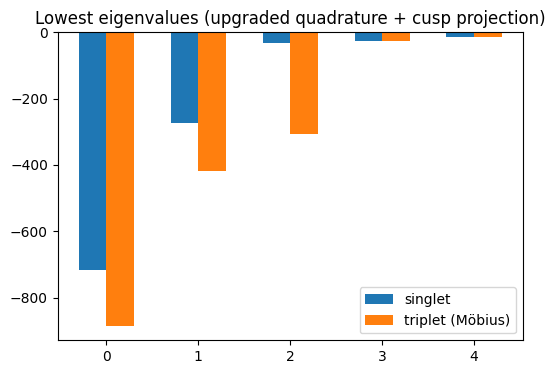

In [ ]:

k=5
x = np.arange(k)
plt.figure(figsize=(6,4))
plt.bar(x-0.15, E_sing[:k], width=0.3, label='singlet')
plt.bar(x+0.15, E_trip[:k], width=0.3, label='triplet (Möbius)')
plt.title('Lowest eigenvalues (upgraded quadrature + cusp projection)')
plt.legend(); plt.show()


### Notes
- Energies are still **not** high-precision; the kinetic part needs analytic Hylleraas operators for true accuracy.
- The cusp enforcement is **numerical** via projection at a few collocation points; you can densify `collocation_rs`.
- Increase `nL,nG` for better convergence (slower). Tune `zeta` and the basis degree `Nmax`.
